In [1]:
%matplotlib inline

import graph_tool as gt
from graph_tool.draw import *
import graph_tool.collection as collection
import graph_tool.all.minimize_nested_blockmodel_dl as minimize_nested_blockmodel_dl
import graph_tool.generation as gen
import axelrod as axl
import pandas as pd
import toolz as tz
import numpy as np  
import matplotlib.pyplot as plt
from random import choice, sample, random
from copy import deepcopy
from collections import Counter
from time import time
from math import floor, sqrt
from itertools import product
import seaborn as sns
import asyncio

 

In [2]:
from time import time

In [3]:
from collections.abc import Iterable
def flatten(x):
    if isinstance(x, Iterable):
        return sum([flatten(i) for i in x], [])
    return [x]

In [4]:
# project params
outputPath = './sf.png'
DEBUG=False

'''Utils'''
def transposeList(l) = list(map(list, zip(*l)))
def timeFn(text, fn):
    start = time()
    res = fn()
    end = time()
    if DEBUG:
        print(text + f' took {end-start}s')
    return res
def orderTsMatrixPlot(ts, M) = [y for x in  [ts[(M-1-i)::M] for i in range(M)] for y in x] 
    

In [5]:
# network params
_k = 30
N = _N = 500
_m = 2
_c = 0 
_gamma = 1

# game params
_R=1
_P=0
_T=2 # T€[0,2] 
_S=-1 # S€[-1,1]
def genTSParams(M):
    t_ = np.linspace(0,2,M)
    s_ = np.linspace(-1,1,M)
    _ts = product(t_, s_)|>list
    return _ts

# evo params
_episode_n = 100
_te = 1
_ta = 0.5
_W = _te/_ta
_beta = 0.001

In [6]:
'''Init''' 
C = 'C'
D = 'D'
def initStrats(N) = np.random.choice([C,D],N)
def initPayoffs(N) = np.zeros(N)

'''Graph'''
# returns the number k
def uniform(k):
    return k
# returns a number betwee 1 and k
def randSample(max):
    accept = False
    while not accept:
        k = np.random.randint(1,max+1)
        accept = np.random.random() < 1.0/k
    return k
# returns a new scale free graph
def initScaleFreeGraph(N=_N, m=_m, c=_c, gamma=_gamma) = gen.price_network(N=N, m=m, c=c, gamma=gamma, directed=False)
# returns a new random graph
def initRandomGraph(N=_N, k=_k) = gt.generation.random_graph(N, x->randSample(k), directed=False)
# returns a new random graph with a uniform degree distribution
def initUniformRandomGraph(N=_N, k=30) = gt.generation.random_graph(N, x->uniform(k), directed=False)
# sample one neighbor of node id in a graph, return none if no neighbors


In [7]:
# get first degree neighbors of the nodes ids
def getNeighbors(graph, ids):
    return flatten([graph.get_all_neighbors(id) for id in ids]) |> set |> list
# get a list of for the nth degree neighbors between 0 and n
def getNthNeighbors(graph, id, n):
    nthNeighbors = [[id]] + [[] for i in range(n)] 
    for i in range(n):
        nthNeighbors[i+1] = getNeighbors(graph, nthNeighbors[i])
    return nthNeighbors

In [8]:
def sampleStrat(strats, strat) = enumerate(strats) |> filter$(x-> x[1] == strat) |> map$(.[0]) |> list |> eligible -> None if not eligible else (np.random.choice(eligible) )


def isFinished(graph, triedList):
    return len(triedList) == graph.num_vertices()
# sample neighbors of x filtered by a function prioritizing closest neighbors and moving outward in rings if none available
def filterEgoSample(graph, filterFn, ids):
#     print(f"filterEgoSample: {ids}")
    neighbors = getNeighbors(graph, ids)
#     print(f"filterEgoSample neighbors: {neighbors}")
    elligibleNeighbors = filter(filterFn, neighbors) |> list
#     print(f"filterEgoSample eligible: {elligibleNeighbors}")
    if not elligibleNeighbors:
        if isFinished(graph, neighbors):
            return None
        return filterEgoSample(graph, filterFn, neighbors)
    return np.random.choice(elligibleNeighbors)


In [9]:
# exclude first neighbors
def filterEgoSampleUnique(graph, filterFn, id):
    excludeFirstNeighbors = x -> x not in ([id] + list(graph.get_all_neighbors(id)))
    return filterEgoSample(graph, x -> excludeFirstNeighbors(x) and filterFn(x), [id])

In [10]:
def sampleEgoStrat(graph, strats, strat, id):
    return filterEgoSampleUnique(graph, x->strats[x]==strat, id)

In [11]:
''' Neighbor Sampling'''
def sampleNeighbor(graph, id):
    neighbors = graph.get_all_neighbors(id)
    try:
        neigh = np.random.choice(neighbors) 
        return neigh
    except:
        return None
# sample one neighbor of node id1 in a graph, excluding id2 and its neighbors 
def sampleNeighborUnique(graph, id1, id2):
     neighbors = list(set(graph.get_all_neighbors(id1)) - set(graph.get_all_neighbors(id2)) - set([id2]))
     return np.random.choice(neighbors) if neighbors else None 
# sample any second degree neighbor of node id by random sampling a firt degree neighbor and then sampling its neighbors
def sampleSecondNeighbor(graph, id):
    firstNeighbor = sampleNeighbor(graph, id)
    secondNeighbor = sampleNeighbor(graph, firstNeighbor)
    return secondNeighbor
# sample any second degree neighbor of node id excluding id's first degree neighbors
def sampleSecondNeighborUnique(graph, id):
    firstNeighbors = graph.get_all_neighbors(id)
    for fN in np.random.shuffle(firstNeighbors):
        secondNeighbor = sampleNeighborUnique(graph, fN, id)
        if secondNeighbor:
            return secondNeighbor
    return None 
#checks if node has only 1 edge
def isLonely(graph, x) = graph.vertex(x).out_degree() == 1 
# SIDE EFFECT: replaces the graph's edge (x,y) with edge (x,z)
def rewireEdge(graph, x, y, z):
    graph.remove_edge(graph.edge(x,y))
    graph.add_edge(x, z)
    return graph
# neighbors of b eligible for rewiring a to 
def eligibleNewFriends(graph, b, a) = set(graph.get_all_neighbors(b)) - set(graph.get_all_neighbors(a)) - set([a]) |> list
# samples a node of a given strat from the list strats, returns its id
def sampleStrat(strats, strat) = enumerate(strats) |> filter$(x-> x[1] == strat) |> map$(.[0]) |> list |> eligible -> None if not eligible else (np.random.choice(eligible) )
def sampleStratEligible(graph, strats, strat, x):
    ofStrat = enumerate(strats) |> filter$(x-> x[1] == strat) |> map$(.[0]) |> list
    if not ofStrat:
        return None 
    else:
        eligible = set(ofStrat) - set(graph.get_all_neighbors(x)) - set([x]) |> list
        if not eligible:
            return None
        return np.random.choice(eligible)


In [12]:
'''Games'''
# Dictionary of game weights given T and S. R=1, P=0
def makeWeightDict(t,s) = {'R':_R, 'P':_P, 'T':t, 'S':s}
# Returns a dictionary that maps the strategies played to payoffs received for a set of 4 payoff metric
def makeDilemma(R=_R, P=_P, T=_T, S=_S) = {C:{C:[R,R], D:[S,T]}, D:{C:[T,S], D:[P,P]}} # T€[0,2] S€[-1,1]
# Returns a dictionary that maps the strategies played to payoffs received for T and S (canonical form of a 2x2)
def makeTSDilemma(t,s) = makeDilemma(**makeWeightDict(t,s))
dilemma = makeDilemma()
# Returns the payoff as a function of the dilemma, the ids and strats of the players
# playDilemma :: [strat] -> id -> id -> float
def playDilemma(dilemma, strats, id1, id2) = dilemma[strats[id1]][strats[id2]]
# cumulativePayoffs :: graph -> [strat] # Cumulative Payoff of 1 round of a node playing all its neighbors
def nodeCumPayoffs(dilemma, graph, strats, x):
    try:
        payoffs = [playDilemma(dilemma, strats, x, y)[0] for y in graph.get_all_neighbors(x)]
        return sum(payoffs)
    except:
        return 0
# Pair of cumulative payoffs 
def pairCumPayoffs(dilemma, graph, strats, a, b):
    return [nodeCumPayoffs(dilemma, graph, strats, a), nodeCumPayoffs(dilemma, graph, strats, b)]
        

In [13]:
'''Mediators'''
# No mediator, recommends a neighbor of y 
# noMediator :: graph -> id -> id -> id
# def useNoMed(graph, strats, y, x) = sampleSecondNeighborUnique(graph,x)
def useNoMed(graph, strats, y, x):
    eligible = eligibleNewFriends(graph, y, x)
    return None if not eligible else np.random.choice(eligible)

# Recommends a random cooperator
# goodMediator :: graph -> id -> id -> id
def useGoodMed(graph, strats, y, x):
    z = sampleStratEligible(graph, strats, C, x)
    return None if not z else z

# Recommends a random defector
# badMediator :: graph -> id -> id -> id
def useBadMed(graph, strats, y, x):
    z = sampleStratEligible(graph, strats, D, x)
    return None if not z else z

# Recommends a random node
# globalRandomMediator :: graph -> id -> id -> id

def useRandomMed(graph, strats, y, x):
    return np.random.choice(list(set(graph.get_vertices()) - set(graph.get_all_neighbors(x)) - set([x])) )

# Recs D to D and C to C
    
def useFairMed(graph, strats, y, x):
    z = sampleStratEligible(graph, strats, strats[int(x)], x)
    return None if not z else z

In [14]:
''' Ego mediators '''
def useLocalGoodMed(graph, strats, y, x) = sampleEgoStrat(graph, strats, C, x)
def useLocalBadMed(graph, strats, y, x) = sampleEgoStrat(graph, strats, D, x)
def useLocalRandomMed(graph, strats, y, x) = filterEgoSampleUnique(graph, x->True, x)
def useLocalFairMed(graph, strats, y, x) = sampleEgoStrat(graph, strats, strats[x], x)


In [15]:
'''Structural Update'''
# Makes a tie update object
def TieUpdate(x,y,z) = {"updateType":"rewire", "x":x, "old":y, "new":z}
# Asks for a recommendation and keeps the same tie if there are no other valid nodes 
def decideRewire(graph, strats, x, y, useMediator):
    if isLonely(graph, y): 
        return TieUpdate(x,y,y) #enforcing graph connectedness
    z = useMediator(graph, strats, y, x)
    if not z:
        return TieUpdate(x,y,y) #enforcing graph connectedness
    return TieUpdate(x,y,z)
# Decides whether a rewire should happen based on x and y's strats. If x is satisfied, nothing happens
def calcStructuralUpdate(beta, graph, dilemma, strats, _x, _y, p, useMediator):
    x,y = int(_x), int(_y)
    if (strats[x] == C and strats[y] == D):
        doRewire = random() < p        
        if doRewire:
            return decideRewire(graph, strats, x, y, useMediator)
        else:
            return TieUpdate(x,y,y)
    elif (strats[x] == D and strats[y] == D):
        keepX = random() < p
        args = [x,y] if keepX else [y,x]
        return decideRewire(graph, strats, args[0], args[1], useMediator)
    return TieUpdate(x,y,y)
# Applies a tie update to the graph
def updateTies(graph, tieUpdate):
    return rewireEdge(graph, tieUpdate["x"], tieUpdate["old"], tieUpdate["new"])
    
'''Strategy Evolution'''
# fermi formula, pairwise comparison
def fermi(beta, fitness_diff) = 1. / (1. + np.exp(-1 * beta * np.clip(fitness_diff, 0,None), dtype=np.float64))
# 
# def calcK(graph, x, y) = max(graph.vertex(x).out_degree(), graph.vertex(y).out_degree())
# def calcD(T=_T, S=_S) = max(T, 1) - min(S, 0)
# def transProb(calcK, P, x, y) = (P[y] - P[x]) / (calcK(x, y) * calcD())

# Returns a strategy update object
# updateStrat :: graph -> [strat] -> [float] -> id -> strat
def calcStrategyUpdate(beta, graph, dilemma, strats, x, y, p):
    doChangeStrat = random() < p  
    new = strats[y] if doChangeStrat else strats[x]
    return {"updateType":"strat", "x":x, "old":strats[x], "new":new}
# Applies a strategy update to the graph
def updateStrat(strats, update):
    strats[update["x"]] = update["new"]
    return strats


In [16]:
# Runs a single evolution episode: either a strategy or a structural update to node x, based the timescale ratio W
def runEvolutionEp(N, beta, W, dilemma, graph, strats, history, _x, useMediator, saveHistory=False):
    _y = sampleNeighbor(graph, _x)
    x,y = int(_x), int(_y)
    px, py = pairCumPayoffs(dilemma, graph, strats, x, y)
#     print(f"x {x}({strats[x]}, {px}), y {y}({strats[y]}, {py})")
    p = fermi(beta, py - px)      
    random_number = np.random.rand() * (1+W)
    doStratUpdate = random_number <= 1
    if doStratUpdate:
        stratUpdate = calcStrategyUpdate(beta, graph, dilemma, strats, x, y, p)
        if saveHistory:
            history.append(stratUpdate)
        strats = updateStrat(strats, stratUpdate)
    else:
        graphUpdate = calcStructuralUpdate(beta, graph, dilemma, strats, _x, _y, p, useMediator)
        if saveHistory:
            history.append(graphUpdate)
        graph = updateTies(graph, graphUpdate)
    return strats, graph, history

# Initializes strats, payoffs, history, graph and runs many evolution episodes, each for a random node x
# runEvolution :: int -> graph -> [strat] -> [float] -> [[strat]]
def runEvolution(N, episode_n, W, dilemma, strats, beta = 0.001, _graph=None, k=None, useMediator=useNoMed, history=None, saveHistory=False):
    history = [] if history == None else history
    print(f"starting runEvolution, history len= {len(history)}, {'saving history, ' if saveHistory else ''} N={N}, episode_n={episode_n}, useMediator={useMediator.__name__}")
    initStrats = deepcopy(strats)
    totalPayoffs = initPayoffs(N)
#     history = [] #[{updateType: "strat", x: N, old: {C,D}, new: {C,D}}, {updateType: "rewire", xy: (x,y), old: (x,y), new: (x,z)}]
    graph = deepcopy(_graph) if _graph else initUniformRandomGraph(N=N, k=(k if k else _k))
    for i in range(episode_n):
        x = np.random.randint(N)
        strats, graph, history = runEvolutionEp(N, beta, W, dilemma, graph, strats, history, x, useMediator, saveHistory)
        if i % 250 == 0:
            counts = Counter(strats)
            if counts[C] == N or counts[D] == N: 
                break
    return {"graph":graph, "history":history, "initStrats":initStrats, "finalStrats":deepcopy(strats)}

# Runs evolution, times it
def runExperiment(N=_N, episode_n=_episode_n, W=_W, graph=None, ts=(_T,_S), strats=None, beta = 0.005, k=None, useMediator=useNoMed, history=[], saveHistory=False):
    print(f'Starting experiment history len= {len(history)} N={N}, epN={episode_n} W={W}, ts={ts}, beta={beta}, k={k} took {floor(end-start)}s')
    start = time()
    strats = deepcopy(strats) if strats else initStrats(N)
    experimentResults = runEvolution(N, episode_n, W, makeTSDilemma(*ts), deepcopy(strats), beta, deepcopy(graph), k, useMediator, history, saveHistory=False)
    end = time()
    print(f'running experiment N={N}, epN={episode_n} W={W}, ts={ts}, beta={beta}, k={k} took {floor(end-start)}s')
    return experimentResults

# Runs one experiment for each game configuration in a MxM matrix os T,S values
def runTSExperiment(M, N=_N, episode_n=_episode_n, W=_W, graph=None, strats=None, beta = 0.005, k=None, useMediator=useNoMed, saveHistory=False):
    start = time()
    strats = deepcopy(strats) if strats else initStrats(N)
    ts = genTSParams(M)
    results = {(t,s):runEvolution(N=N, episode_n=episode_n, W=W, dilemma=makeTSDilemma(t,s), strats=deepcopy(strats), beta=beta, _graph=deepcopy(graph), k=k, useMediator=useMediator, saveHistory=(True if (t,s)==(2,-1) else False)) for t,s in ts}
    end = time()
    print(f'running t,s experiment N={N}, epN={episode_n} W={W}, beta={beta} took {floor(end-start)}s')
    return results

# Runs many experiments, one for each value in argDict
def runManyExperiments(argDict):
    return {key: runExperiment(**args) for key,args in argDict.items()}
# Runs many TS experiments, one for each value in argDict
def runManyTSExperiments(argDict):
    return {key: runTSExperiment(**args) for key,args in argDict.items()}

#deprecated
def runWExperiments(ws, M=9, N=100, episode_n=2, graph=None, beta = 0.005):
    return {w: runTSExperiment(M, N, episode_n=episode_n, W=w, graph=graph) for w in ws}
#deprecated
def runMediatorExperiments(meds, M=9, N=100, episode_n=2, graph=None, strats=None, k=None, beta = 0.001):
    return {useMediator.__name__: runTSExperiment(M, N, episode_n=episode_n, W=w, graph=graph, useMediator=useMediator) for useMediator in meds}


In [17]:
def continueTSExperiment(args, res):
    prevGraphs = {k:v['graph'] for k,v in res.items()}
    prevStrats = {k:v['finalStrats'] for k,v in res.items()}
    prevHistories = {k:v['history'] for k,v in res.items()}
    start = time()
    print(f'running t,s experiment N={N}, epN={episode_n} W={W}, beta={beta}')
    ts = genTSParams(M)
    results = {(t,s):runEvolution(N=args['N'], episode_n=args['episode_n'], W=args['W'], dilemma=makeTSDilemma(t,s), strats=deepcopy(prevStrats[(t,s)]), beta=args['beta'], graph=deepcopy(prevGraphs[(t,s)]), k=args['k'], useMediator=args['useMediator'], history=deepcopy(prevHistories[(t,s)])) for t,s in ts}
    end = time()
    print(f'running t,s experiment N={N}, epN={episode_n} W={W}, beta={beta} took {floor(end-start)}s')
    return results

In [18]:
# Plots
def drawGraph(graph, strats=None, mplfig=None):
    strats = strats if strats else [None for i in range(graph.num_vertices())] 
    strat2Color = {C:'green', D:'red', None: 'gray'}
    color = graph.new_vertex_property("string")
    for i,strat in enumerate(strats):
        color[graph.vertex(i)] = strat2Color[strat]#
    if mplfig:
        print('drawing graph as subplot')
        graph_draw(graph, bg_color="white", vertex_fill_color=color, mplfig=mplfig) 
    else:
        graph_draw(graph, bg_color="white", vertex_fill_color=color) 
        
def edgeStratColor(e):
    c = (strats[int(e.target())]==C) + (strats[int(e.source())]==C)
    return {0:'red', 1:'orange', 2:'green'}[c]

# plot graph with colored edges 
def plotGraph2(n, graph, strats):
    vIds = graph.new_vertex_property("string")
    stratColors = graph.new_vertex_property("string")
    edgeColors = graph.new_edge_property("string")
    for i in range(n):
        stratColors[i] = {C:'green', D:'red'}[strats[i]]
        vIds[i] = f'{i}'
    for e in graph.edges():
        edgeColors[e] = edgeStratColor(e)
    deg = graph.degree_property_map("out")
    deg.a = 25 * (np.sqrt(deg.a/n))+3
    pos = fruchterman_reingold_layout(graph)
    graph_draw(graph,pos=pos, vertex_text=vIds, vertex_font_size=16, vertex_fill_color=stratColors, vertex_size=deg, edge_color=edgeColors)
    
def plotHist(_list, bins) = pd.Series(_list).plot.hist(bins = bins)
def plotStratEvo(initStrat, history, nSteps=500):
    stratCounts = historyToStratCounts(initStrat, history) 
    stepSize = int(max(np.floor(len(stratCounts)/nSteps), 1))
    pd.DataFrame(stratCounts[::stepSize]).plot.line(color={C:'orange', D:'blue'})

# plot for different initial K, for different beta
def finalCoopsByW(res, game=(2.0,-1.0)) = pd.DataFrame({"W":manyTsRes.keys(), "cooperators":[Counter(manyTsRes[w][game]['episodes'][-1])[C] for w in manyTsRes.keys()]}).plot.line(x="W", y="cooperators")
def finalKMaxByW(res):
    return


def plotDegreeLog(yFn, graph, title='', xlabel="$k$", ylabel="$NP(k)$"):
    hist = gt.stats.vertex_hist(graph, 'out')
    y = yFn(hist[0])
    err = np.sqrt(y)
    err[err >= y] = y[err >= y] - 1e-2
    plt.plot(hist[1][:-1], y, "o", label="degree")
#     plt.errorbar(hist[1][:-1], y, fmt="o", yerr=err,label="in")
    plt.xlabel(xlabel)
    plt.ylabel("$NP(k)$")
    plt.tight_layout()
    ax = plt.gca()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(1e-3, 1.5)
    ax.set_xlim(0.8, 1e3)
    return ax
def plotDD(graph): 
    return plotDegreeLog(y->y/graph.num_vertices(), graph)
def cumulativeSum(y, n) = np.sum(y[n:])
def plotCDD(graph):
    return plotDegreeLog(y->np.flip(np.cumsum(np.flip(y)))/graph.num_vertices(), graph, ylabel="$D(k)$")

def avgSquares(graph) = 
    counts,degrees = gt.stats.vertex_hist(graph,'out')
    np.sum([(degrees[i]**2)*counts[i] for i in range(len(counts))])/graph.num_vertices()
def squaredAvg(graph) = 
    gt.stats.vertex_average(graph,'out')[0]**2

def heterogeneity(graph) = avgSquares(graph) - squaredAvg(graph)
    
def plotLandscape(ts, vals, axis=None, valName=''):
    size = 4
    M = len(vals)
    df = pd.DataFrame(zip(vals, *transposeList(ts)), columns=[valName, 't', 's'])
    df = df.pivot('s', 't', valName).iloc[::-1]
    if not axis:
        fig, ax = plt.subplots(figsize=(size+1,size))         # Sample figsize in inches
        ax = sns.heatmap(df, annot=True, cbar=True, xticklabels=2, yticklabels=2, ax=ax)#.set_title(title)
        #  ax = sns.heatmap(df, annot=False, cbar=True, xticklabels=2, yticklabels=2)#.set_title(title)
        plt.show()
    else:
        ax = sns.heatmap(df, annot=False, cbar=True, xticklabels=2, yticklabels=2, ax=axis)#.set_title(title)
    return ax

def coopCount(finalStrats):
    return Counter(finalStrats)['C']
def coopLandscape(ts, res, title='', axis=None):
    cCounts = [coopCount(r['finalStrats']) for r in res]
    return plotLandscape(ts, cCounts, axis=axis, valName='coop counts')

def heterogeneityLandscape(ts, res, title='', axis=None):
    hVals = [heterogeneity(r['graph']) for r in res]
    return plotLandscape(ts, hVals, axis=axis, valName='heterogeneity')

def maxDegreeLandscape(ts, res, title='', axis=None):
    hVals = [maxDegree(r['graph']) for r in res]
    return plotLandscape(ts, hVals, axis=axis, valName='max degree (k)')


#  cCounts = [Counter(r['episodes'][-1])['C'] for r in res]
#     M = len(cCounts)
#     df = pd.DataFrame(zip(cCounts, *transposeList(ts)), columns=['count', 't', 's'])
#     df = df.pivot('s', 't', 'count').iloc[::-1]
#     if not axis:
#         ax = sns.heatmap(df, annot=False, cbar=True, xticklabels=2, yticklabels=2)#.set_title(title)
#         plt.show()
#     else:
#         ax = sns.heatmap(df, annot=False, cbar=True, xticklabels=2, yticklabels=2, ax=axis)#.set_title(title)
#     return ax



In [19]:
def plotKeysCoopByW(unif_res)=pd.DataFrame({key: [Counter(x['episodes'][-1])[C] for w,x in res.items()] for key, res in unif_res.items()}, index=list(unif_res.values())[0].keys()).plot.line()

def plotKeysMaxKByW(unif_res)=pd.DataFrame({key: [maxDegree(x['graph']) for w,x in res.items()] for key, res in unif_res.items()}, index=list(unif_res.values())[0].keys()).plot.line()

def plotBetasCoopByW(unif_res)=pd.DataFrame({beta: [Counter(x['episodes'][-1])[C] for w,x in res.items()] for beta, res in unif_res.items()}, index=list(unif_res.values())[0].keys()).plot.line()

def plotBetasMaxKByW(unif_res)=pd.DataFrame({beta: [maxDegree(x['graph']) for w,x in res.items()] for beta, res in unif_res.items()}, index=list(unif_res.values())[0].keys()).plot.line()

def maxDegree(graph) = np.max(graph.get_out_degrees(graph.get_vertices()))


In [20]:
def hist2Count(old, new):
    d = {D:{C:1, D:0},  C:{C:0,D:-1}}
    return d[old][new]


def historyToStratCounts(initStrat, history):
    N = len(initStrat)
    initC=Counter(initStrat)[C]
    steps = history |> filter$(x->x["updateType"]=="strat") |> map$(x -> hist2Count(x['old'], x['new'])) |>list
    Cs = np.cumsum(steps)+initC
    Ds = map(c->N-c, Cs)
    return [{C:c, D:d} for c,d in zip(Cs,Ds)]

In [21]:
# Multi Plots
def graphBeforeAfter(graph0, strats0, graph1 ,strats1): # graphs don't show up if we pass them the axis
    size=4
    xn = 2
    yn = 1
    fig, ax = plt.subplots(yn, xn, figsize=(yn*size,xn*size))
    drawGraph(graph0, strats=strats0, mplfig=ax[0])
    drawGraph(graph1, strats=strats1, mplfig=ax[1])
    plt.show()

def plot1D(res, plotFn, title='', keyName=''):
    size = 4
    items = res.items()
    n = len(items)
    fig, ax = plt.subplots(1, n, figsize=((n+1)*size,size))
    fig.suptitle(title, fontsize=16, y=1.08)
    for i,(k,v) in enumerate(items):
        plt.subplot(1,n,i+1)
        ax = plotFn(k,v, keyName)
        
def plot2D(M, res, plotFn, title='', keyName=''):
    size = 4
    items = res.items()
    n = len(items)
    fig, ax = plt.subplots(M, M, figsize=(M*size,M*size))
    fig.suptitle(title, fontsize=16, y=1.08)
    for i,(k,v) in enumerate(items):
        plt.subplot(M,M,M*M-i)
        ax = plotFn(k,v, keyName)

def plotDDFn(k,v, keyName=''):
#     graph, totalPayoffs, episodes = v
    ax = plotDD(v['graph'])
    ax.set_title(f'DD {keyName}={k}')
    return ax
def plotCDDFn(k,v, keyName=''):
    ax = plotCDD(v['graph'])
    ax.set_title(f'CDD {keyName}={k}')
    return ax

def plotStratEvoFn(k,v, keyName=''):
#     graph, totalPayoffs, episodes = v
    stratCounts = historyToStratCounts(v['initStrats'], v['history'])
    ax = pd.DataFrame(stratCounts).plot(color={C:'orange', D:'blue'}, ax=plt.gca())
    ax.set_title(f'{keyName}={k}')
    return ax

def plotHistFn(k,v, keyName=''):
#     graph, totalPayoffs, episodes = v
    ax = plotHist(*gt.stats.vertex_hist(v['graph'], 'out'))
    return ax

def plotCoopLandscapeFn(k,v, keyName=''):
#     ts,res = v
#     ax = coopLandscape(v['ts'], v['results'], title='', axis=plt.gca())
    ax = coopLandscape(v.keys(), v.values(), title='', axis=plt.gca())
    ax.set_title(f'{keyName}={k}')
    return ax

def plotHetLandscapeFn(k,v, keyName=''):
#     ts,res = v
#     ax = heterogeneityLandscape(v['ts'], v['results'], title='', axis=plt.gca())
    ax = heterogeneityLandscape(v.keys(), v.values(), title='', axis=plt.gca())
    ax.set_title(f'{keyName}={k}')
    return ax
def plotMaxDegreeLandscapeFn(k,v, keyName=''):
    ax = maxDegreeLandscape(v.keys(), v.values(), title='', axis=plt.gca())
    ax.set_title(f'{keyName}={k}')
    return ax

# for i in range(M):
#     plot2D(M{ts[M*i+j]:res for j,res in enumerate(results[M*i:M*(i+1)])}, plotStratEvoFn, keyName='t,s')
def plotStratMatrix(tsExpRes):
    _results = orderTsMatrixPlot(list(tsExpRes.values()), M)
#     _results = tsExpRes.values()
#     _ts = tsExpRes.keys()
    _ts = orderTsMatrixPlot(list(tsExpRes.keys()), M)
    tsRes = {ts:res for ts,res in reversed(zip(_ts, _results))}
#     tsRes = {ts:res for ts,res in zip(_ts, _results)}
    return plot2D(M, tsRes, plotStratEvoFn, keyName='t,s')

def plotCDDMatrix(tsExpRes):
    _results = orderTsMatrixPlot(list(tsExpRes.values()), M)
#     _results = tsExpRes.values()
#     _ts = tsExpRes.keys()
    _ts = orderTsMatrixPlot(list(tsExpRes.keys()), M)
    tsRes = {ts:res for ts,res in reversed(zip(_ts, _results))}
#     tsRes = {ts:res for ts,res in zip(_ts, _results)}
    return plot2D(M, tsRes, plotCDDFn, keyName='t,s')


In [22]:
def countUpdateTypes(history):
    updateTypes = history |> map$(.["updateType"])
    return Counter(updateTypes) |> dict

def nEmptyRewires(history):
    return history |> filter$(x->x["updateType"]=="rewire" and x['old'] == x['new']) |> list |> len
def nEmptyStratChanges(history):
    return history |> filter$(x->x["updateType"]=="strat" and x['old'] == x['new']) |> list |>  len

def historyStats(history):
    print(f'countUpdateTypes: {countUpdateTypes(history)}')
    print(f'nEmptyRewires: {nEmptyRewires(history)}')
    print(f'nEmptyStratChanges: {nEmptyStratChanges(history)}')
    

def coopCountsRes(res):
    gameParams = list(res[0].keys())
    coopCounts = {game:list(map(x->coopCount(x[game]['finalStrats']) , res)) for game in gameParams}
    return coopCounts

def fractionsAbsorbCoop(N, res, absorbFraction = 0.90):
    
    nSimulations = len(res)
    coopCounts = coopCountsRes(res)
    gameParams = list(res[0].keys())
    fractions = {game:np.count_nonzero(np.array(coopCounts[game])>=N*absorbFraction)/nSimulations for game in gameParams}
    return fractions 

def avgFractionCoop(N, res):
#     d = max(1, N/1e4)
    d = 1
    coopCounts = coopCountsRes(res)
    gameParams = list(res[0].keys())
    avgs = {game:np.mean(coopCounts[game])/N for game in gameParams}
    return avgs

    
def pickKeyMany(key, obj):
    return map$(obj[key])

def finalExperiment():
    # 100 simulations for each set of parameters (T,S,W)
    absorbFraction = 0.90 
    nSimulations = 10
    for w in ws:
        args['W'] = w
        res = [runTSExperiment(**args) for i in range(nSimulations)]
        # compute fraction of times that evolution stopped at 100% cooperation
        coopCounts = coopCountsRes(res)
        absorbFractions = fractionsAbsorbCoop(N, res, absorbFraction)
        # if no convergence after 10^8 generations
        avgCoopFractions = avgFractionCoop(N,res)
        plotColor = {game:absorbFractions[game] if absorbFractions[game] != 0 else avgCoopFractions[game] for game in gameParams}
        
    # take avg fraction of cooperators over the last 1000 generations
    

In [23]:
# Save to files
def pToStr(param):
    return f"{param[0]}-{param[-1]}" if isinstance(param, list) else str(param)
def makePath(name):
    return f"./data/{name}.pkl"
def renameDuplicate(makePath, name, i=0):
    print(f"renameDuplicate {i}")
    _name = deepcopy(name)
    if i != 0:
        _name = f'{_name} ({i})'
    if os.path.exists(makePath(_name)):
        return renameDuplicate(makePath, name, i+1)
    return _name 
def makeExperimentName(useMediator, N,M,episode_n,beta,W,k):
    baseName = f"{useMediator.__name__}_N-{pToStr(N)}_M-{pToStr(M)}_episoden-{pToStr(episode_n)}_beta-{pToStr(beta)}_W-{pToStr(W)}_k-{pToStr(k)}"
    return baseName
def saveRes(res, _name):
    name = renameDuplicate(makePath, _name)
    os.makedirs('./data', exist_ok=True)
    path = makePath(name)
    with open(path, "wb+") as file:
        pickle.dump(res, file)
        print(f"saved {name}.pkl")
def loadRes(name):
    with open(f"./data/{name}.pkl", "rb") as file:
        res = pickle.load(file)
        print(f"loaded {name}.pkl")
        return res 

# Paper experiments

In [24]:
N = 500
M = 6
episode_n = 400000
graph0 = initUniformRandomGraph(N)
beta = 0.005
W = []
k = 30

In [130]:
#Debug
N = 500
M = 2
episode_n = 100
graph0 = initUniformRandomGraph(N)
beta = 0.005
W = []
k = 30

# No Mediator

In [28]:
useMediator = useNoMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
noMedRes=runManyTSExperiments(argDict)

starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode

starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0, saving history,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useNoMed
starting runEvolution, history len= 0,

In [29]:
saveRes(noMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

renameDuplicate 0
saved useNoMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


In [16]:
noMedRes = loadRes("useNoMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useNoMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

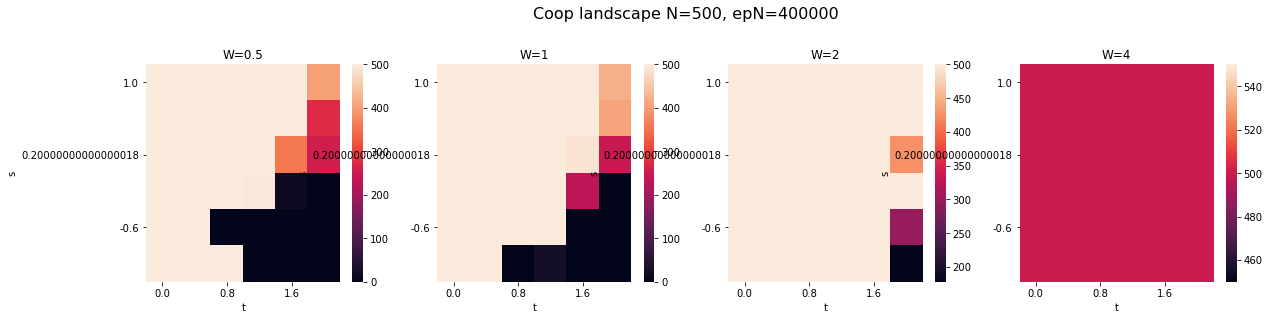

In [18]:
plot1D(noMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

In [56]:
# plotStratMatrix(noMedRes[2])

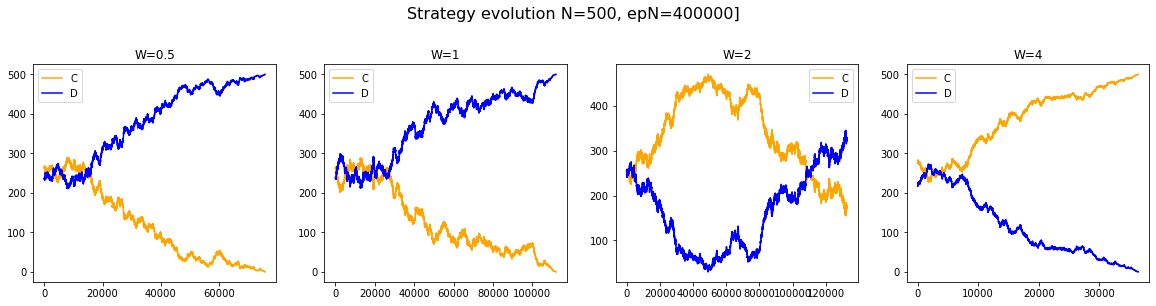

In [20]:
plot1D({k:v[(2,-1)] for k,v in noMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

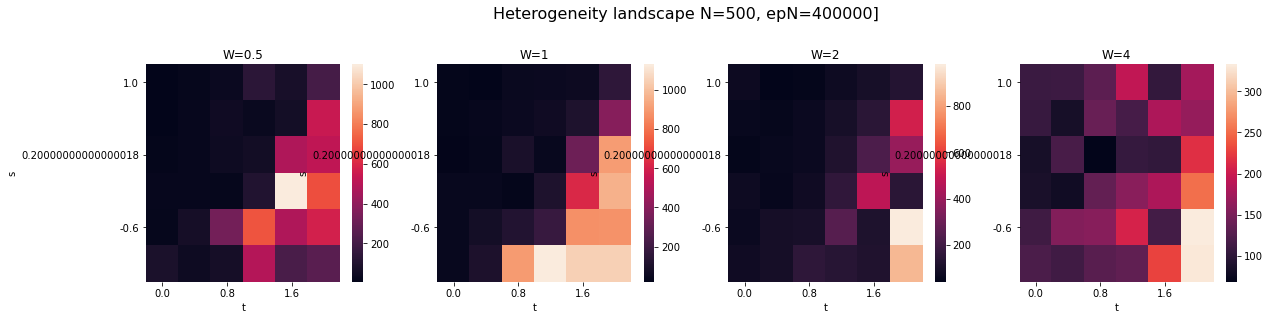

In [21]:
plot1D(noMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Max Degree landscape

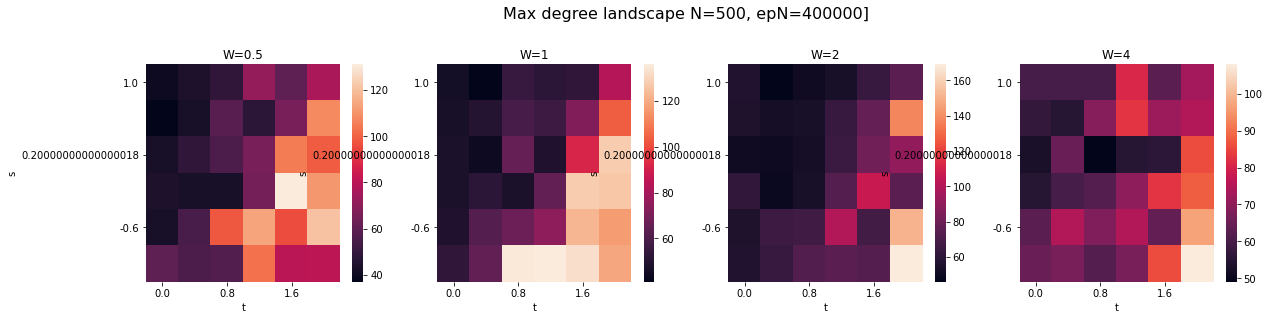

In [22]:
plot1D(noMedRes, plotMaxDegreeLandscapeFn, f'Max degree landscape N={N}, epN={episode_n}]', 'W')

### Final cumulative degree distributions

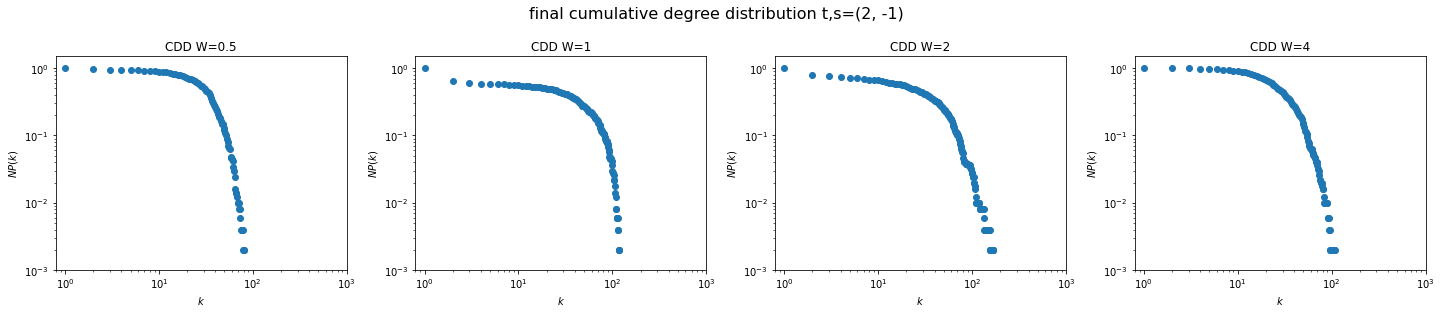

In [23]:
plot1D({k:v[(2.0,-1.0)] for k,v in noMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Perfect Mediator

In [79]:
useMediator = useGoodMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
noMedRes=runManyTSExperiments(argDict)

runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000,

runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
runEvolution, , N=500, episode_n=400000, useMediator=useGoodMed
saving history
runEvolution, saving history, N=500, episode_n=400000, useMediator=useGoodMed
runEvolutio

In [80]:
saveRes(goodMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

renameDuplicate 0
saved useGoodMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


In [24]:
goodMedRes = loadRes("useGoodMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useGoodMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

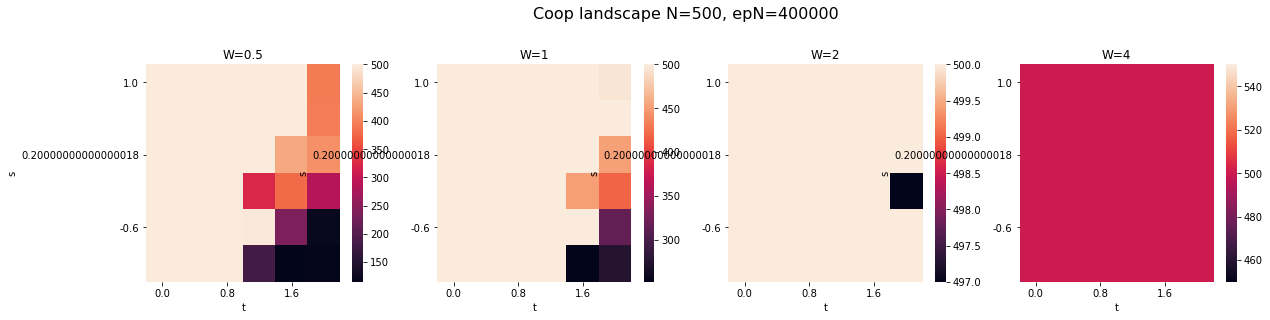

In [25]:
plot1D(goodMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

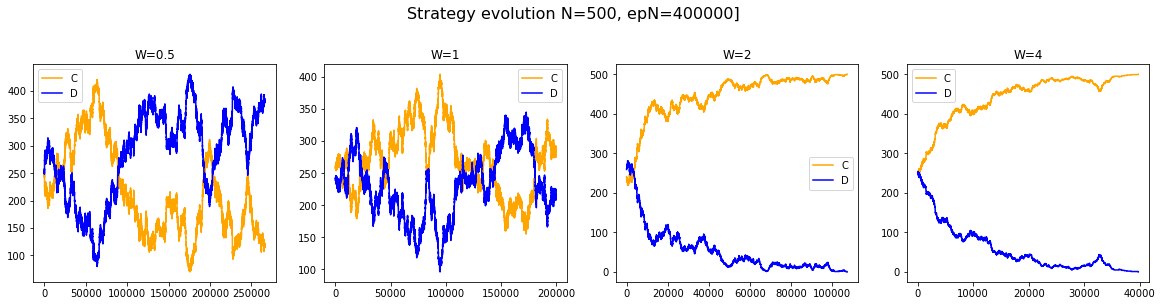

In [26]:
plot1D({k:v[(2,-1)] for k,v in goodMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

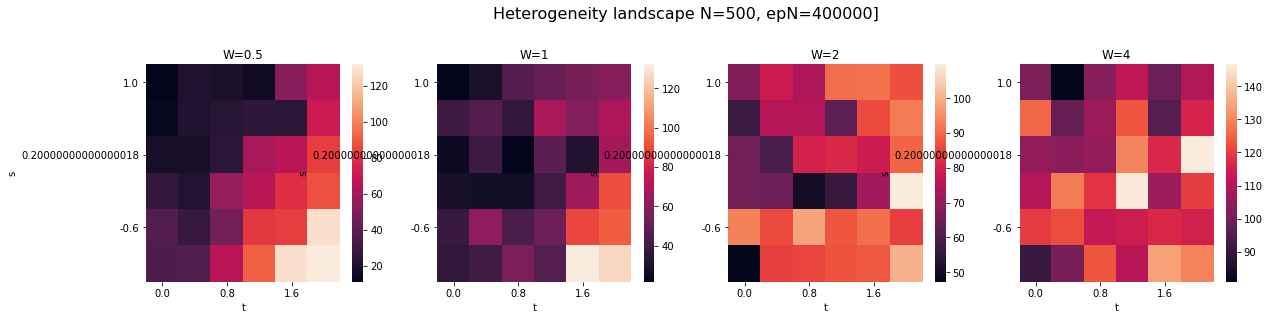

In [27]:
plot1D(goodMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Final degree distributions

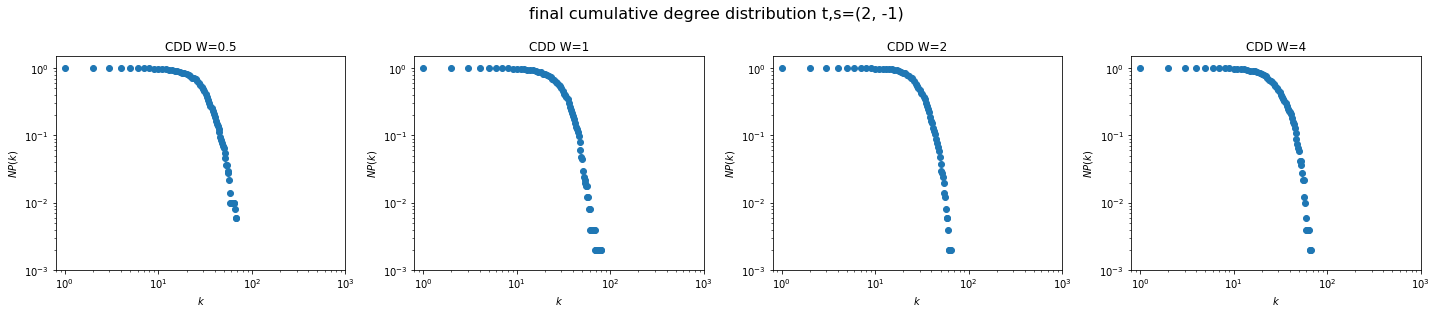

In [28]:
plot1D({k:v[(2.0,-1.0)] for k,v in goodMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Bad Mediator

In [24]:
useMediator = useBadMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
noMedRes=runManyTSExperiments(argDict)

saving history
running t,s experiment N=500, epN=1000 W=0, beta=0.005 took 3s
saving history
running t,s experiment N=500, epN=1000 W=0.5, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=1, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=2, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=4, beta=0.005 took 4s


In [ ]:
saveRes(badMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

In [31]:
badMedRes = loadRes("useBadMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useBadMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

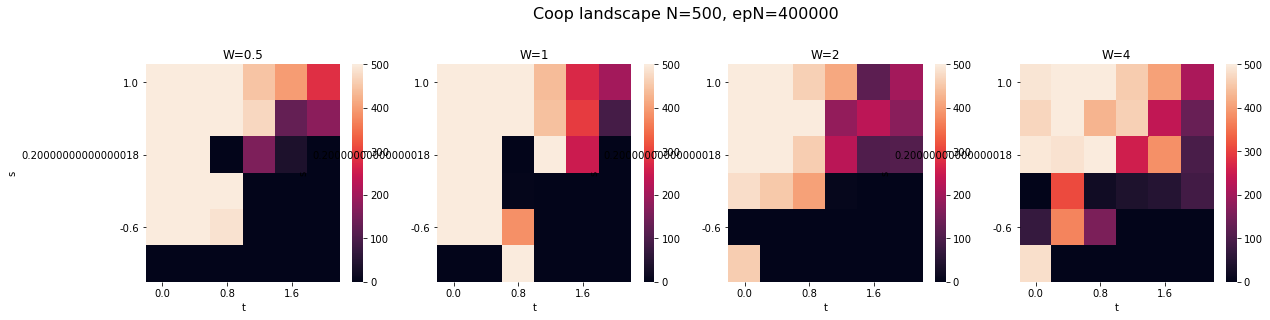

In [32]:
plot1D(badMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

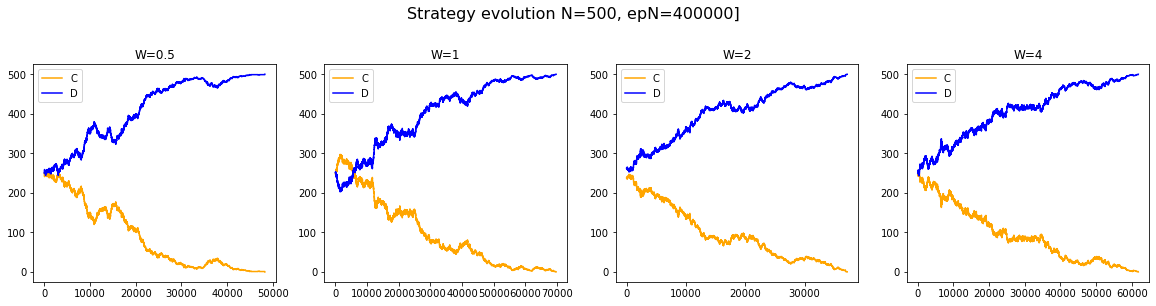

In [33]:
plot1D({k:v[(2,-1)] for k,v in badMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

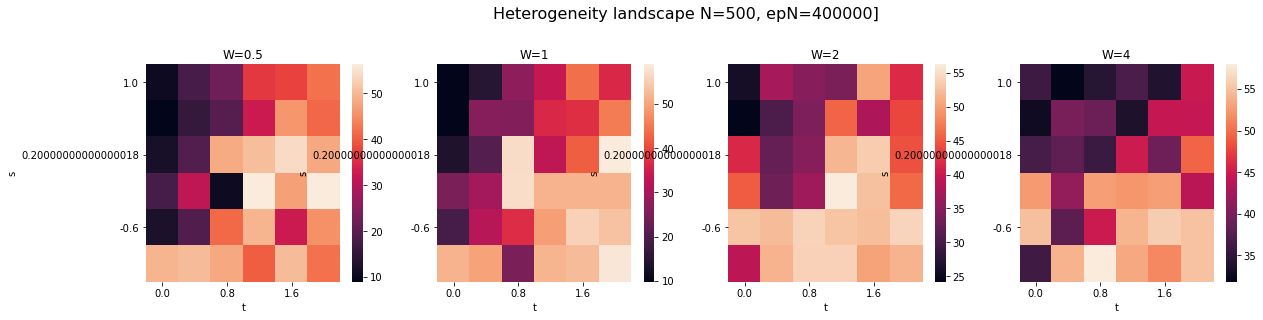

In [34]:
plot1D(badMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Final degree distributions

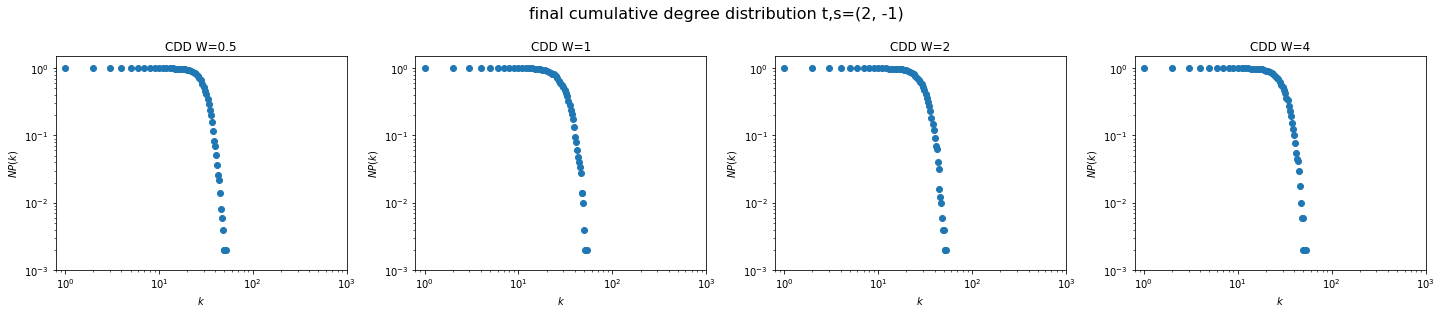

In [35]:
plot1D({k:v[(2.0,-1.0)] for k,v in badMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Random Mediator

In [25]:
useMediator = useRandomMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
noMedRes=runManyTSExperiments(argDict)

saving history
running t,s experiment N=500, epN=1000 W=0, beta=0.005 took 3s
saving history
running t,s experiment N=500, epN=1000 W=0.5, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=1, beta=0.005 took 5s
saving history
running t,s experiment N=500, epN=1000 W=2, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=4, beta=0.005 took 5s


In [ ]:
saveRes(randomMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

In [37]:
randomMedRes = loadRes("useRandomMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useRandomMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

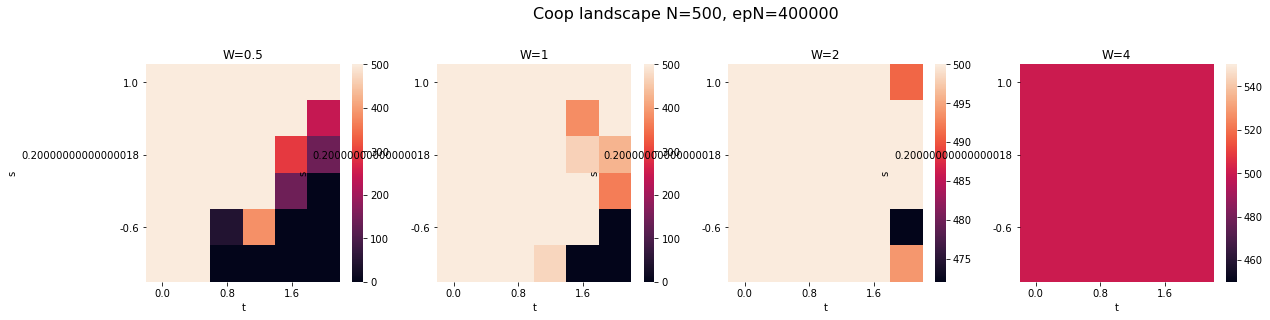

In [38]:
plot1D(randomMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

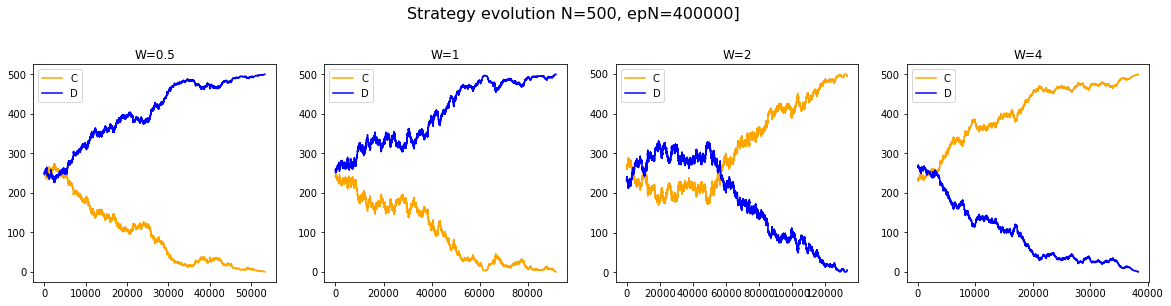

In [39]:
plot1D({k:v[(2,-1)] for k,v in randomMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

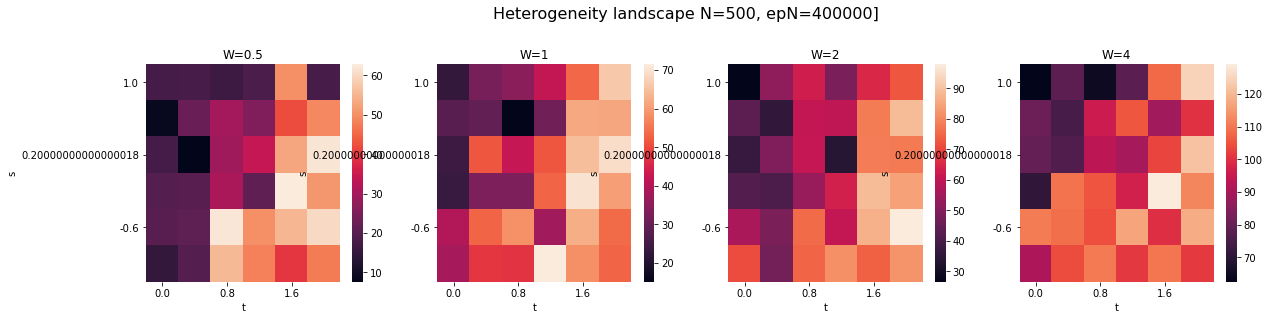

In [40]:
plot1D(randomMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Final degree distributions

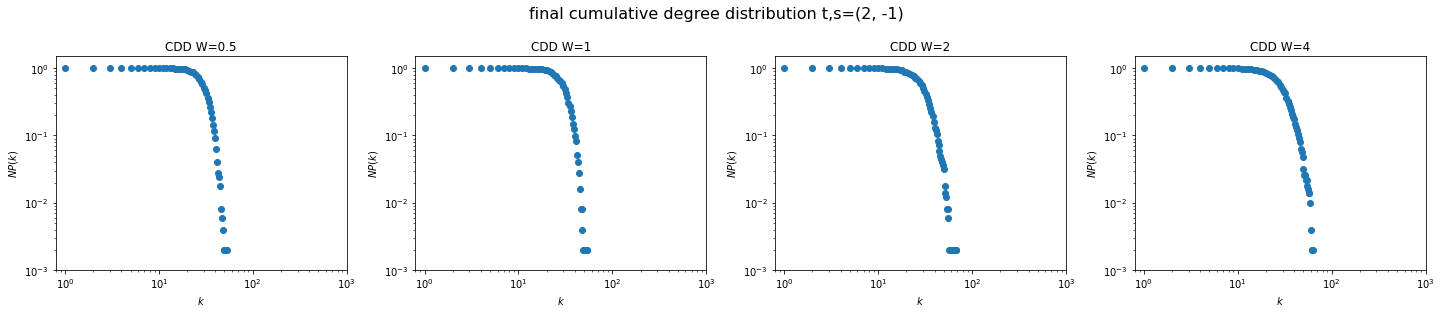

In [41]:
plot1D({k:v[(2.0,-1.0)] for k,v in randomMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Fair Mediator

In [25]:
useMediator = useFairMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
fairMedRes=runManyTSExperiments(argDict)

saving history
running t,s experiment N=500, epN=1000 W=0, beta=0.005 took 3s
saving history
running t,s experiment N=500, epN=1000 W=0.5, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=1, beta=0.005 took 5s
saving history
running t,s experiment N=500, epN=1000 W=2, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=4, beta=0.005 took 5s


In [ ]:
saveRes(fairMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

In [81]:
fairMedRes = loadRes("useFairMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useFairMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

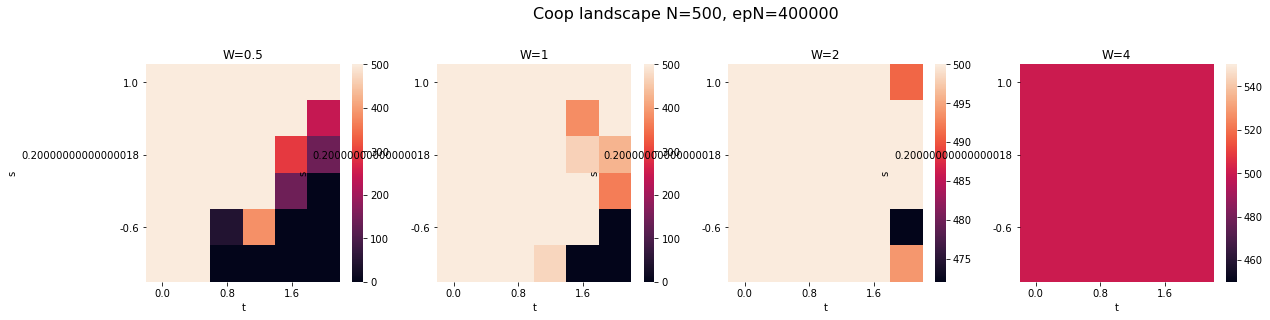

In [38]:
plot1D(fairMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

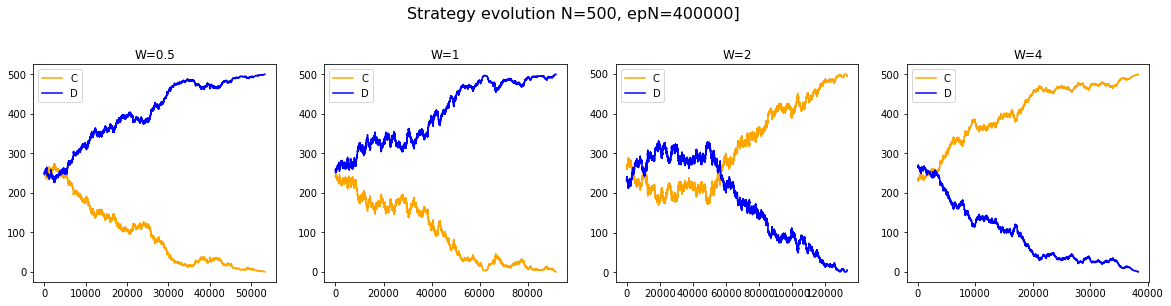

In [39]:
plot1D({k:v[(2,-1)] for k,v in fairMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

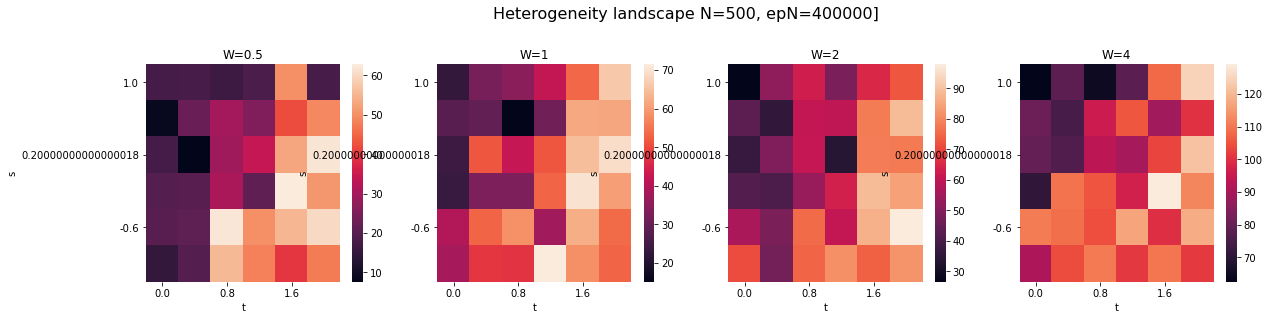

In [40]:
plot1D(fairMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Final degree distributions

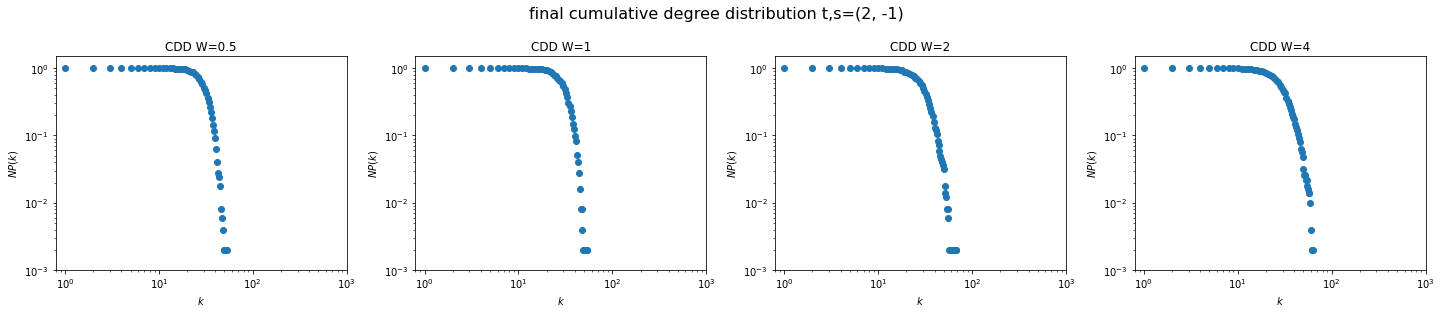

In [41]:
plot1D({k:v[(2.0,-1.0)] for k,v in fairMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Local-biased mediators

## Local Perfect Mediator

In [244]:
useMediator = useLocalGoodMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
goodLocalMedRes=runManyTSExperiments(argDict)

starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMe

starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalGoodMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMe

In [245]:
saveRes(goodLocalMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

renameDuplicate 0
saved useLocalGoodMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


In [24]:
goodLocalMedRes = loadRes("useLocalGoodMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useGoodMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

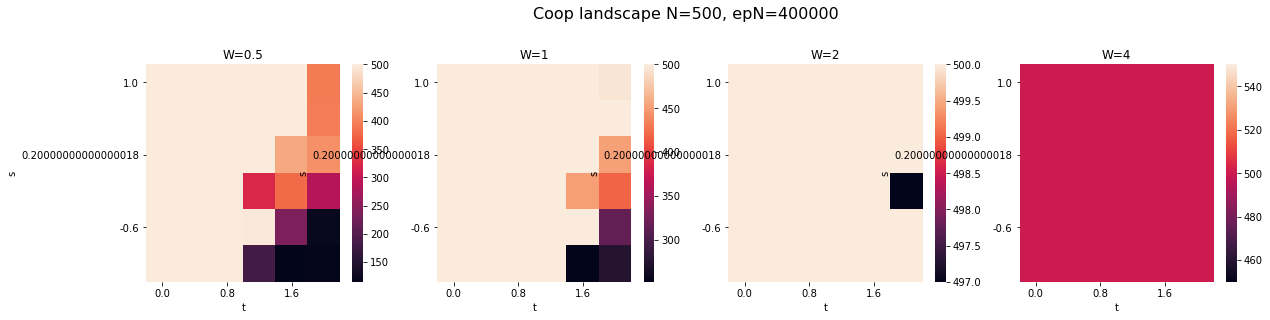

In [25]:
plot1D(goodLocalMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

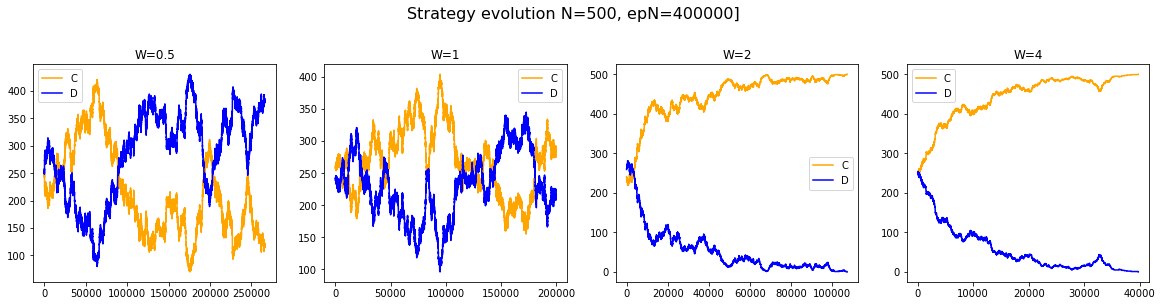

In [26]:
plot1D({k:v[(2,-1)] for k,v in goodLocalMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

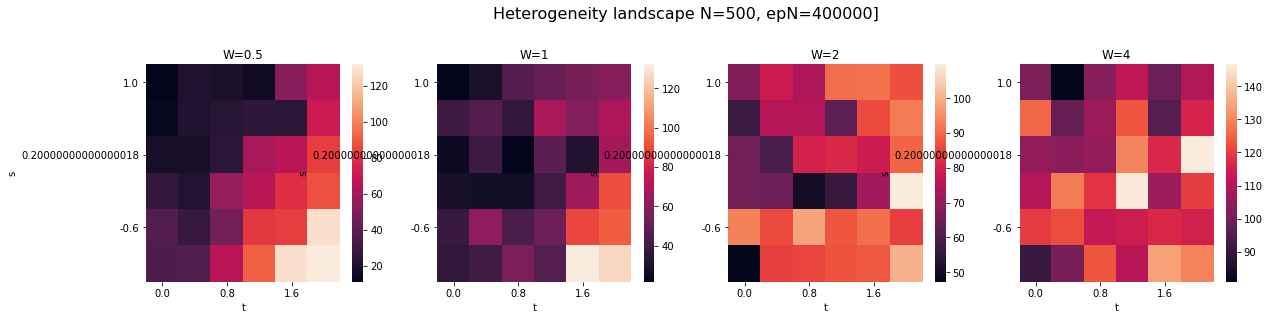

In [27]:
plot1D(goodLocalMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Final degree distributions

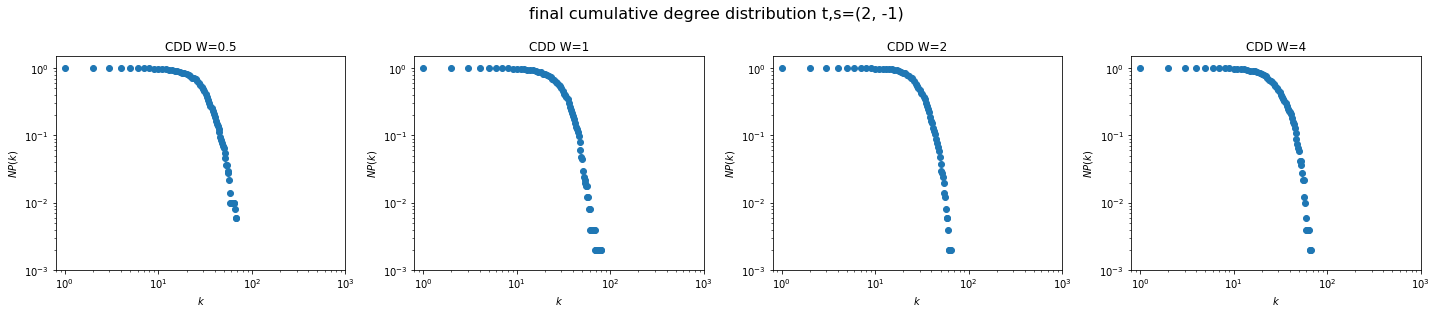

In [28]:
plot1D({k:v[(2.0,-1.0)] for k,v in goodLocalMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Local Bad Mediator

In [25]:
useMediator = useLocalBadMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
badLocalMedRes=runManyTSExperiments(argDict)

starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=use

starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalBadMed
starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=use

In [26]:
saveRes(badLocalMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

renameDuplicate 0
saved useLocalBadMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


In [31]:
badMedRes = loadRes("useLocalBadMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useBadMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

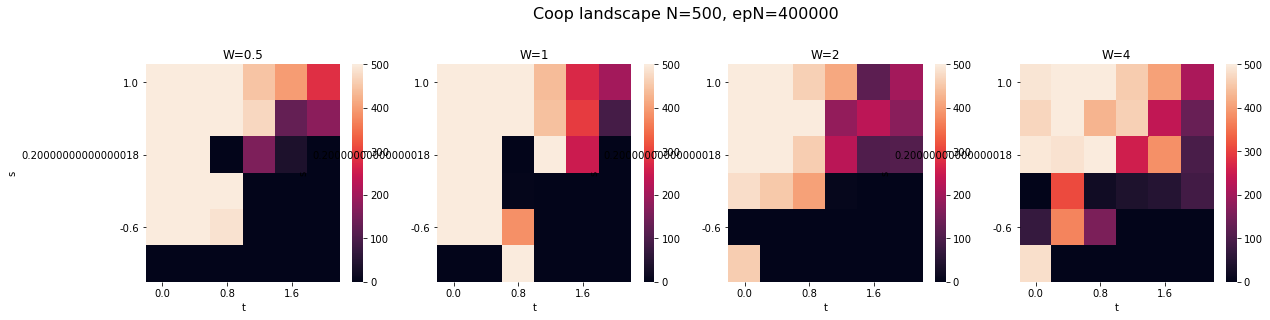

In [32]:
plot1D(badLocalMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

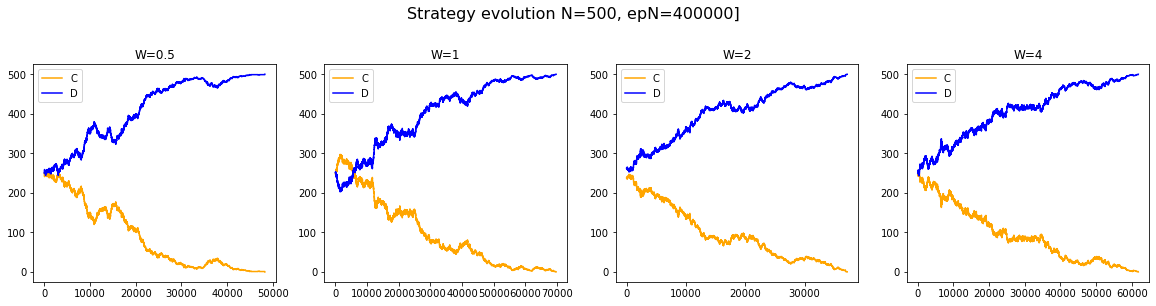

In [33]:
plot1D({k:v[(2,-1)] for k,v in badLocalMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

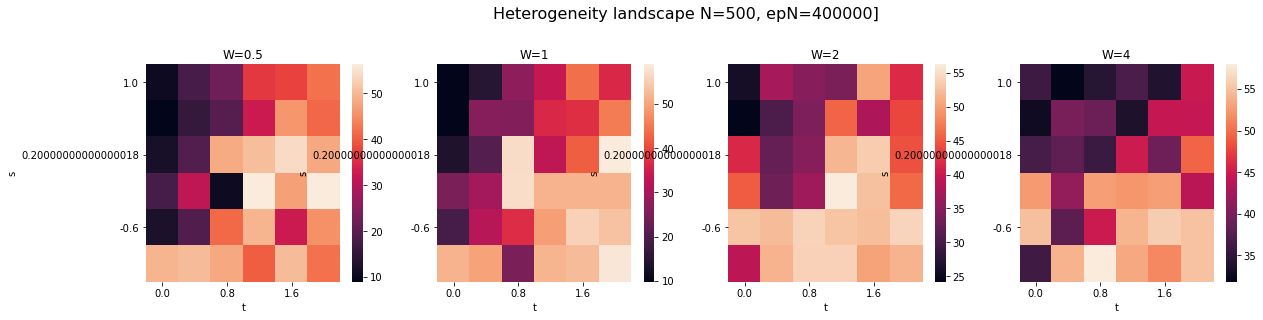

In [34]:
plot1D(badLocalMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Final degree distributions

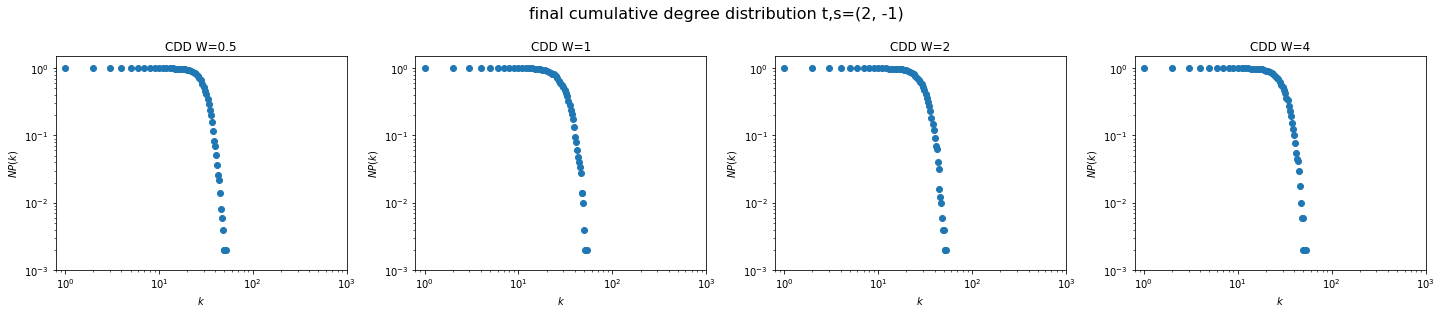

In [35]:
plot1D({k:v[(2.0,-1.0)] for k,v in badLocalMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Local Random Mediator

In [25]:
useMediator = useLocalRandomMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
randomLocalMedRes=runManyTSExperiments(argDict)

saving history
running t,s experiment N=500, epN=1000 W=0, beta=0.005 took 3s
saving history
running t,s experiment N=500, epN=1000 W=0.5, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=1, beta=0.005 took 5s
saving history
running t,s experiment N=500, epN=1000 W=2, beta=0.005 took 4s
saving history
running t,s experiment N=500, epN=1000 W=4, beta=0.005 took 5s


In [ ]:
saveRes(randomLocalMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

In [37]:
randomMedRes = loadRes("useLocalRandomMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useRandomMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

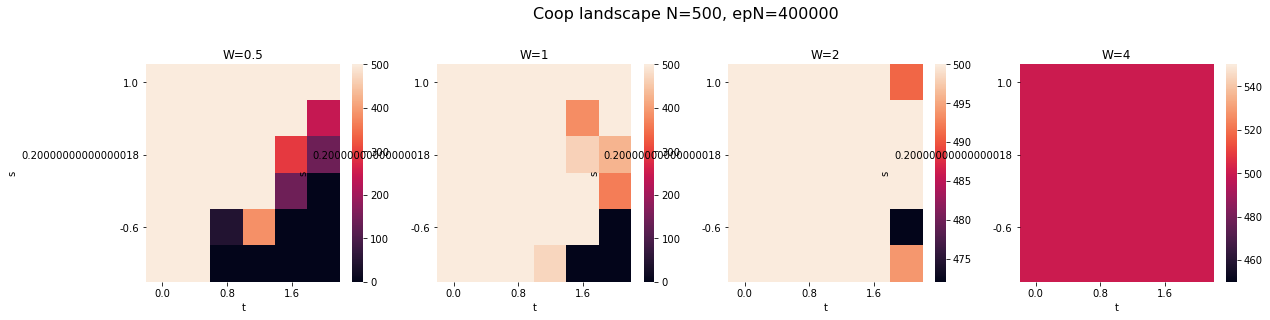

In [38]:
plot1D(randomLocalMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

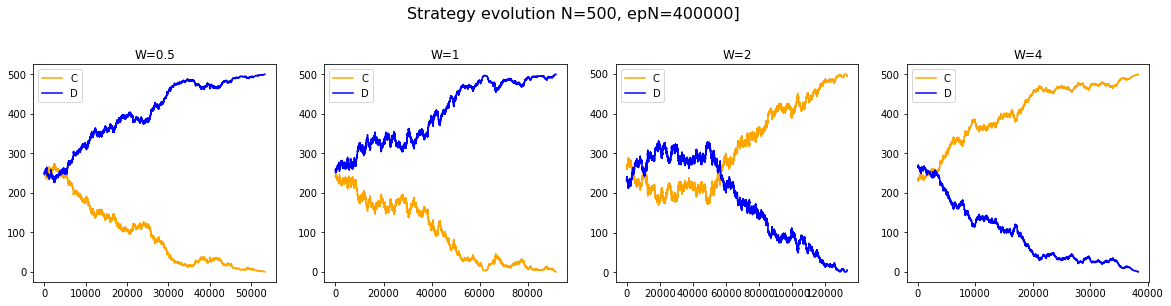

In [39]:
plot1D({k:v[(2,-1)] for k,v in randomLocalMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

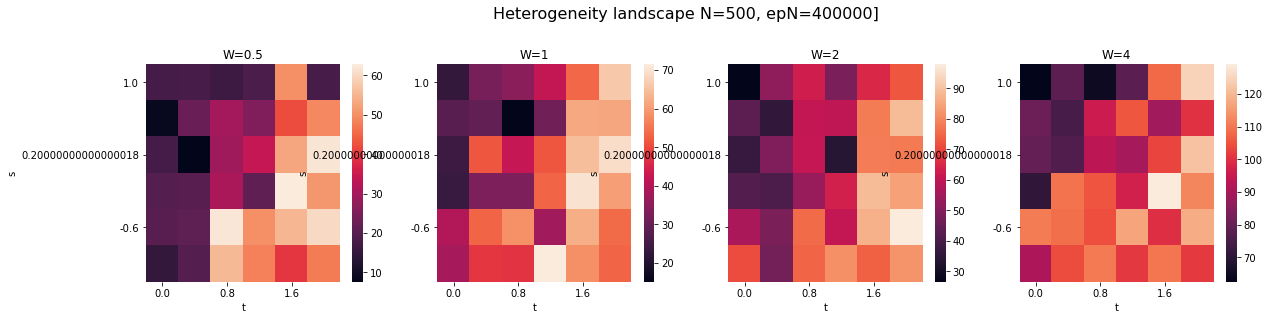

In [40]:
plot1D(randomLocalMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Final degree distributions

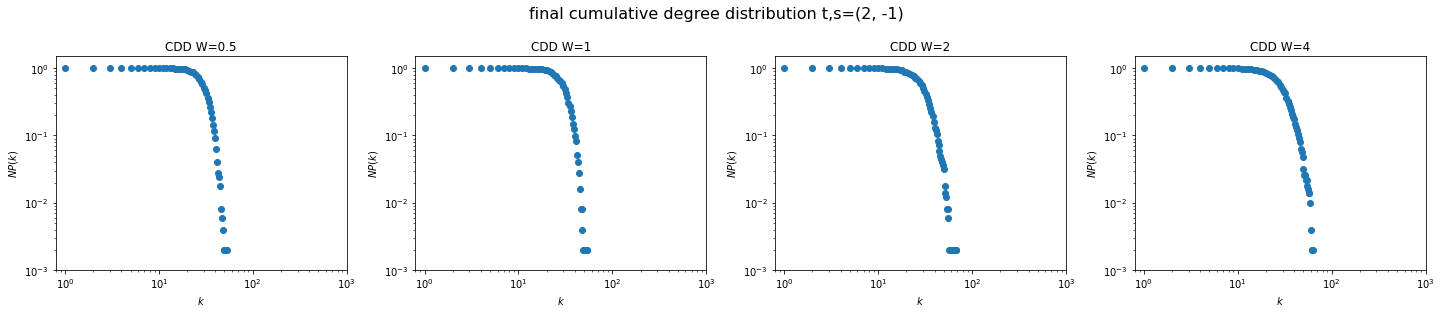

In [41]:
plot1D({k:v[(2.0,-1.0)] for k,v in randomLocalMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Local Fair Mediator

In [ ]:
useMediator = useLocalFairMed
ws = [0.5, 1, 2, 4]
argDict = {w:{"N":N, "M":M, "graph":initUniformRandomGraph(N), "episode_n":episode_n, "beta":beta, "W":w, "k":k, "useMediator":useMediator} for w in ws}
fairLocalMedRes=runManyTSExperiments(argDict)

starting runEvolution, history len= 0,  N=500, episode_n=400000, useMediator=useLocalFairMed


In [ ]:
saveRes(fairLocalMedRes, makeExperimentName(useMediator,N,M,episode_n,beta,W=ws,k=k))

In [81]:
fairLocalMedRes = loadRes("useLocalFairMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30")

loaded useFairMed_N-500_M-6_episoden-400000_beta-0.005_W-0.5-4_k-30.pkl


### Cooperation landscape (Cooperation as a function of game parameters)

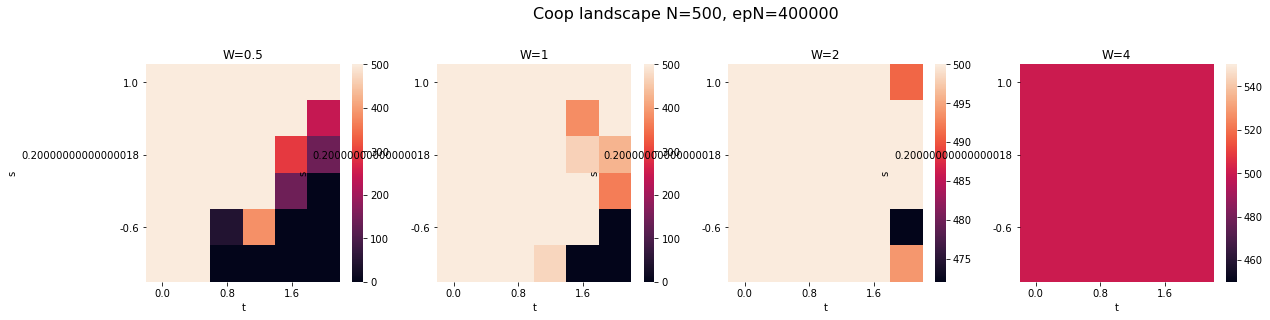

In [38]:
plot1D(fairLocalMedRes, plotCoopLandscapeFn, f'Coop landscape N={N}, epN={episode_n}', 'W')

### Evolution of cooperation

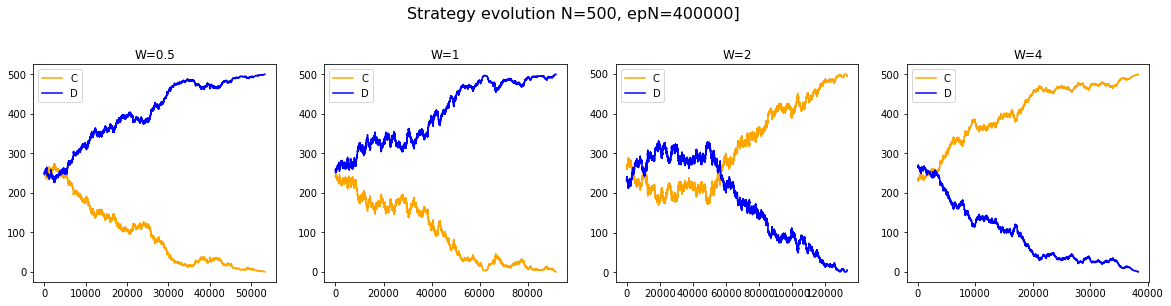

In [39]:
plot1D({k:v[(2,-1)] for k,v in fairLocalMedRes.items()}, plotStratEvoFn, f'Strategy evolution N={N}, epN={episode_n}]', 'W')

### Heterogeneity landscape

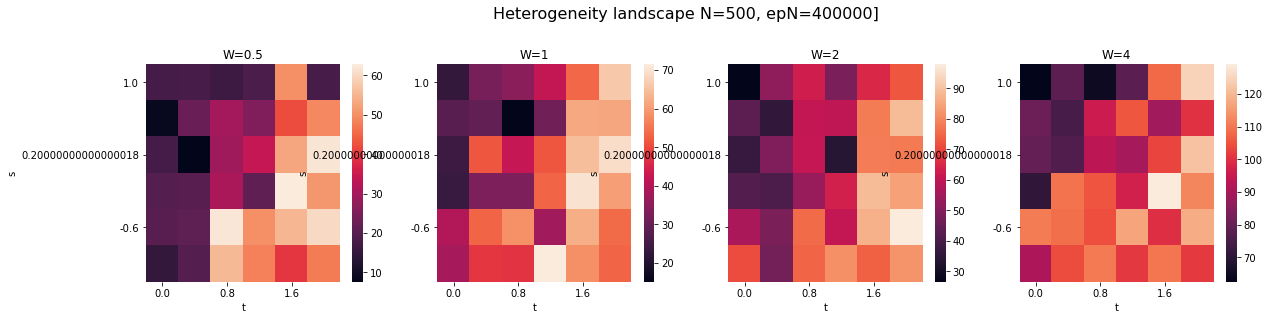

In [40]:
plot1D(fairLocalMedRes, plotHetLandscapeFn, f'Heterogeneity landscape N={N}, epN={episode_n}]', 'W')

### Final degree distributions

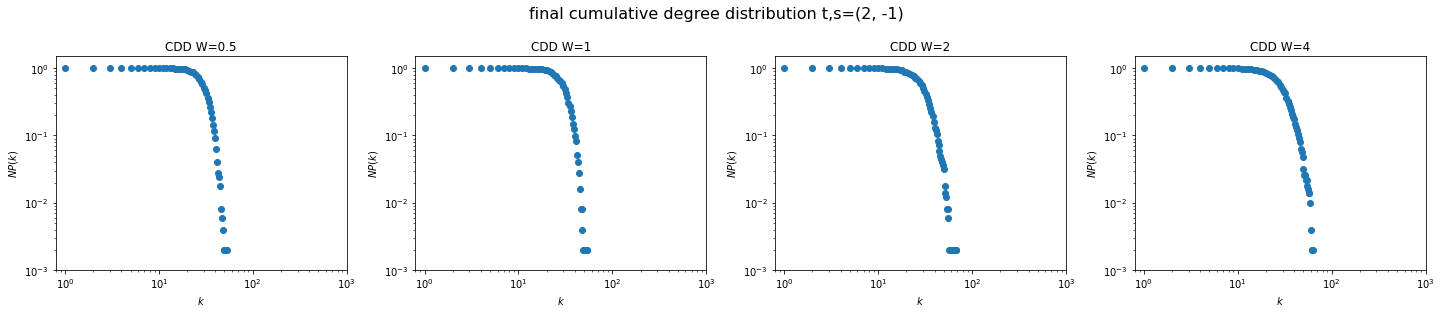

In [41]:
plot1D({k:v[(2.0,-1.0)] for k,v in fairLocalMedRes.items()}, plotCDDFn, 'final cumulative degree distribution t,s=(2, -1)', 'W') # cumulative degree distribution

# Performance optimization

In [14]:
!pip install line_profiler

In [126]:
%load_ext line_profiler

In [5]:
def makeArgs():
    N = 500
    M=5
    episode_n = 1000
    graph0 = initUniformRandomGraph(N)
    beta = 0.005
    W = 0
    k=30
    args = {"N":N, "M":M, "graph":graph0, "episode_n":episode_n, "beta":beta, "W":W, "k":k}
    return args

def profFunction():
    args = makeArgs()
    res = runTSExperiment(**args)


In [16]:

# runEvolution :: int -> graph -> [strat] -> [float] -> [[strat]]
def _runEvolution(N, episode_n, W, dilemma, strats=None, beta = 0.001, graph=None, k=None, useMediator=useNoMed):
    totalPayoffs = initPayoffs(N)
    strats = deepcopy(strats) if strats else initStrats(N)
    history = [] #[{updateType: "strat", x: N, old: {C,D}, new: {C,D}}, {updateType: "rewire", xy: (x,y), old: (x,y), new: (x,z)}]
    graph = deepcopy(graph) if graph else initUniformRandomGraph(N=N, k=(k if k else _k))
    for i in range(episode_n):
        x = np.random.randint(N)
        strats, graph, history = runEvolutionEp(N, beta, W, dilemma, graph, strats, history, x, useMediator)
        if i % 10 == 0:
            counts = Counter(strats)
            if counts[C] == N or counts[D] == N: 
                break
    return {"graph":graph, "history":history, "initStrats":initStrats, "finalStrats":deepcopy(strats)}


In [24]:
%lprun -f _runEvolution _runEvolution(500, 10000, 2, makeTSDilemma(2,-1))

In [27]:
def makeEvoEpArgs():
    N = 500
    graph0 = initUniformRandomGraph(N)
    beta = 0.005
    W = 1
    dilemma=makeTSDilemma(2,-1)
    strats=initStrats(N)
    history=[]
    useMediator=useNoMed
    x=1
    args={"_x":x,"N":N, "graph":graph0, "beta":beta, "W":W, "dilemma":dilemma, "strats":strats, "history":history, "useMediator":useMediator}
    return args

def _runEvolutionEp(N, beta, W, dilemma, graph, strats, history, _x, useMediator, saveHistory=False):
    _y = sampleNeighbor(graph, _x)
    x,y = int(_x), int(_y)
    px, py = pairCumPayoffs(dilemma, graph, strats, x, y)
#     print(f"x {x}({strats[x]}, {px}), y {y}({strats[y]}, {py})")
    p = fermi(beta, py - px)      
    random_number = np.random.rand() * (1+W)
    doStratUpdate = random_number <= 1
    if doStratUpdate:
        stratUpdate = calcStrategyUpdate(beta, graph, dilemma, strats, _x, _y, p)
        if saveHistory:
            history.append(stratUpdate)
        strats = updateStrat(strats, stratUpdate)
    else:
        graphUpdate = calcStructuralUpdate(beta, graph, dilemma, strats, _x, _y, p, useMediator)
        if saveHistory:
            history.append(graphUpdate)
        graph = updateTies(graph, graphUpdate)
    return strats, graph, history



In [31]:
%lprun -f _runEvolutionEp _runEvolutionEp(**makeEvoEpArgs())

In [54]:
def fermi(beta, fitness_diff):
    fitness_diff = np.clip(fitness_diff, 0, None)
    big = np.exp(-1 * beta * fitness_diff, dtype=np.float64)
    return 1. / (1. + big)
    
%lprun -f fermi fermi(0.005, np.random.randint(-20, 20))

In [76]:
def makeStructArgs():
    N=500
    graph0 = initUniformRandomGraph(N)
    beta = 0.005
    dilemma=makeTSDilemma(2,-1)
    strats=initStrats(N)
    useMediator=useNoMed
    x=np.random.randint(1, N-1)
    y=np.random.randint(1, N-1)
    args={"_x":x, "_y":y, "p":random(), "graph":graph0, "beta":beta,"dilemma":dilemma, "strats":strats, "useMediator":useMediator}
    return args

def _calcStructuralUpdate(beta, graph, dilemma, strats, _x, _y, p, useMediator):
    x,y = int(_x), int(_y)
    sx, sy = strats[x],strats[y]
    res = TieUpdate(x,y,y)
    if (sx == C and sy == D):
        doRewire = random() < p        
        if doRewire:
            res = decideRewire(graph, strats, x, y, useMediator)
        else:
            res = TieUpdate(x,y,y)
    elif (sx == D and sy == D):
        keepX = random() < p
        args = [x,y] if keepX else [y,x]
        res = decideRewire(graph, strats, args[0], args[1], useMediator)
    return res


In [79]:
%lprun -f _calcStructuralUpdate _calcStructuralUpdate(**makeStructArgs())

In [80]:
def makeRewireArgs():
    N=500
    graph0 = initUniformRandomGraph(N)
    beta = 0.005
    strats=initStrats(N)
    useMediator=useNoMed
    x=np.random.randint(N)
    y=np.random.randint(N)
    args={"x":x, "y":y, "graph":graph0, "strats":strats, "useMediator":useMediator}
    return args

def _decideRewire(graph, strats, x, y, useMediator):
    # if isLonely(graph, x) or isLonely(graph, y): 
    if isLonely(graph, y): 
        tieUp = TieUpdate(x,y,y) #enforcing graph connectedness
        return tieUp
    # z = sampleNeighborUnique(graph, y, x)
    z = useMediator(graph, strats, y, x)
    if not z:
        tieUp = TieUpdate(x,y,y) #enforcing graph connectedness
        return tieUp
    tieUp = TieUpdate(x,y,z) #enforcing graph connectedness
    return tieUp


In [81]:
%lprun -f _decideRewire _decideRewire(**makeRewireArgs())

In [89]:
def eligibleNewFriends(graph, b, a):
    bs = graph.get_all_neighbors(b)
    _as = graph.get_all_neighbors(a)
    x = set(bs) - set(_as) - set([a])
    xs = list(x)
    return xs

def useNoMed(graph, strats, y, x) = sampleSecondNeighborUnique(graph,x)


In [126]:
%lprun -f eligibleNewFriends eligibleNewFriends(graph, np.random.randint(N), np.random.randint(N))

In [1140]:
def makeStratArgs():
    graph0 = initUniformRandomGraph(N)
    beta = 0.005
    dilemma=makeTSDilemma(2,-1)
    strats=initStrats(N)
    x=1
    args={"x":x,"graph":graph0, "beta":beta,"dilemma":dilemma, "strats":strats}
    return args

def _calcStrategyUpdate(beta, graph, dilemma, strats, x):
    y = _sampleNeighbor(graph, x)
    _x,_y = int(x), int(y)
    px, py = pairCumPayoffs(dilemma, graph, strats, x,y)
    if px > py:
        return {"updateType":"strat", "x":_x, "old":strats[_x], "new":strats[_x]}
    p = fermi(beta, py - px)     
    doChangeStrat = random() < p  
    new = strats[_y] if doChangeStrat else strats[_x]
    return {"updateType":"strat", "x":_x, "old":strats[_x], "new":new}    

In [1157]:
%lprun -f _calcStrategyUpdate _calcStrategyUpdate(**makeStratArgs())

In [223]:
def makeCumPayoffsArgs():
    graph0 = initUniformRandomGraph(N)
    dilemma=makeTSDilemma(2,-1)
    strats=initStrats(N)
    x=1
    args={"x":x,"graph":graph0, "dilemma":dilemma, "strats":strats}
    return args
def playDilemma(dilemma, strats, id1, id2) = dilemma[strats[id1]][strats[id2]]
def _nodeCumPayoffs(dilemma, graph, strats, x):
    payoffs = [playDilemma(dilemma, strats, x, y)[0] for y in graph.get_all_neighbors(x)]
    payoff = sum(payoffs)
    return payoff



In [231]:
%lprun -f _nodeCumPayoffs _nodeCumPayoffs(**makeCumPayoffsArgs())